In [172]:
import os
import glob
from collections import OrderedDict

import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import Holt
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [2]:
%load_ext autoreload
%autoreload 1
%aimport summary.utils
from summary import utils


In [3]:
# from pathlib import Path

# def de_norm(pred, criteria):
    
#     df_std = pd.read_pickle(os.path.join(Path(os.getcwd()).parents[0],'df_std.pkl'))
#     df_mean = pd.read_pickle(os.path.join(Path(os.getcwd()).parents[0],'df_mean.pkl'))
#     std = df_std[criteria]
#     mean = df_mean[criteria]
    
#     return (pred * std) + mean

# Load Data

In [178]:
# Data to play with

c_type = 'step'
imp = 'mice'
inter = 'nointer'
i= 0

base_dir = os.path.abspath(os.getcwd())

dirpath = os.path.join(base_dir, 'data')
y_test_30 = pd.read_pickle(os.path.join(dirpath, f"Y_{c_type}_30_test_{imp}_{inter}_{i}.pkl"))
X_test_30 = pd.read_pickle(os.path.join(dirpath, f"X_{c_type}_30_test_{imp}_{inter}_{i}.pkl"))

y_test_30 = utils.de_norm(y_test_30, criteria = 'P_sys_q0.5')

In [96]:
tr_dict = OrderedDict()
X_test_30['y_test_30']  = y_test_30['sys_30']
ids = X_test_30['hadm_id'].unique()

for idx in ids:
    tr_dict[idx] = utils.de_norm(X_test_30.loc[X_test_30.hadm_id == idx, 'y_test_30'].values, criteria='P_sys_q0.5')

## Normal Range

A naive step function implementation for samples that exceed the thersholds. For Sys thersholds are set to [90,180] to address hypotension and severe hypertension.

In [98]:
un = {}

for k,v in tr_dict.items():
    un[k] = utils.f_norm_naive_sys(v)

In [139]:
# get pred data

# file = open(os.path.join(os.getcwd(), 'scatters','30_mice.pkl'), 'rb')
with open(os.path.join(base_dir, dirpath, '30_mice.pkl'), 'rb') as file:
    sct = pkl.load(file)
ridge_test_30 = sct['30_bp_step_nointer_mice_ridge'][0]['pred_test']
xbg_test_30 = sct['30_bp_step_nointer_mice_xgb'][0]['pred_test']
ridge_test_30 == xbg_test_30

array([False, False, False, ..., False, False, False])

In [187]:
pred_tr_dict = OrderedDict()
pred_tr_dict['Ridge'] = dict()
pred_tr_dict['XGBoost'] = dict()
pred_tr_dict['Naive'] = dict()

X = X_test_30.copy()

X['y_test_30']  = ridge_test_30
X['y_test_30_xgb']  = xbg_test_30

for idx in ids:
    pred_tr_dict['Ridge'][idx] = X.loc[X.hadm_id == idx, 'y_test_30'].values
    pred_tr_dict['XGBoost'][idx] = X.loc[X.hadm_id == idx, 'y_test_30_xgb'].values
    pred_tr_dict['Naive'][idx] = utils.de_norm(X.loc[X.hadm_id == idx, 'P_sys_q0.5'].values, 'P_sys_q0.5')

In [141]:
# pred_trends_dict = utils.trend(pred_tr_dict)
# pred_trends_dict_new, distance_dict, res_dict = utils.get_trend(pred_tr_dict, True)


In [188]:
un_pred = {}
un_pred['Ridge'] = dict()
un_pred['XGBoost'] = dict()
un_pred['Naive'] = dict()

for model in pred_tr_dict.keys():
    for k,v in pred_tr_dict[model].items():
        un_pred[model][k] = utils.f_norm_naive_sys(v)

# Normal Range Evaluation Measures

\begin{equation}
\begin{split}
    \frac{1}{n}\sum_{i}\max\left(0, (|f_{norm}\left(y_i\right)| - |f_{norm}\left(y^{pred}_i\right)\right|) + \max(0, -sign(f_{norm}(y_i) \cdot sign(f_{norm}(y^{pred}_i))\\
    \frac{1}{n}\sum_{i}\max\left(0, |f_{norm}\left(y^{pred}_i\right)| - |f_{norm}\left(y_i\right)\right|) + \max(0, -sign(f_{norm}(y_i)) \cdot sign(f_{norm}(y^{pred}_i))
\end{split}
\end{equation}

In [189]:
# consider making it per patient as well

model = 'XGBoost'

print(f'missing important: {utils.f_norm_eval(un, un_pred[model])}')
print(f'false alarm: {utils.f_norm_eval(un_pred[model], un)}')


missing important: 0.03214765153133425
false alarm: 0.012732584709991158


## Trend Utility

According to distance from Holt ES naive prediction.

In [190]:
trends_dict = utils.trend(tr_dict)
trends_dict_new, res_dict = utils.get_trend(tr_dict, True)

/home/bar/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function trend is deprecated; This is old version. Don't Use!
  warnings.warn(msg, category=FutureWarning)
/home/bar/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/bar/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/home/bar/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/home/bar/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


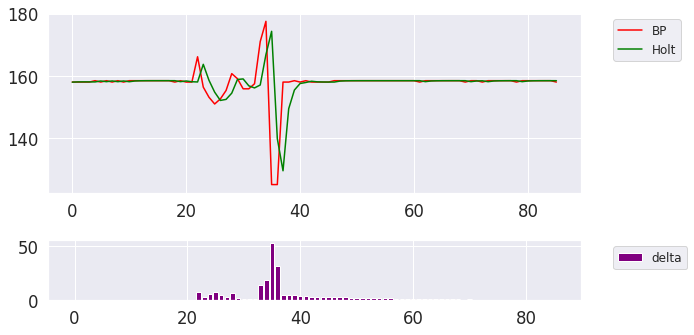

In [148]:
i=105123
s_test = tr_dict[i]
# pred=trends_dict[i]
new_trend = trends_dict_new[i]
delta=abs(s_test - pred)
sns.set(font_scale=1.5)

fig, ax = plt.subplots(2,1, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(range(len(s_test)), s_test, label="BP",color='red');
# ax[0].plot(range(len(s_test)), pred, label="Original");
ax[0].plot(range(len(s_test)), new_trend, label="Holt", color='green');

ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 12});

ax[1].bar(range(len(s_test)), delta, label="delta",color='purple');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 12});
fig.tight_layout()

# Trend Based Evaluation


\begin{equation}
\begin{split}
    W_{g}(y_i)\cdot |y_i - y^{pred}_i|\\
    W_{g}(y^{pred}_i)\cdot |y_i - y^{pred}_i|
\end{split}
\end{equation}


In [191]:
g_norm_true = utils.get_g_norm(tr_dict, trends_dict_new)

# calculate per model
g_norm_pred = dict()
for model in ['XGBoost', 'Ridge', 'Naive']:
    g_norm_pred[model] = utils.get_g_norm(pred_tr_dict[model], trends_dict_new)

In [115]:
# Calc Weights

# holt_values = [v for k,v in trends_dict.items()]

# u_max = max(np.hstack(values))
# print(f'u_max: {u_max}')

# values = [v for k,v in pred_trends_dict.items()]
# u_max_pred = max(np.hstack(values))
# print(f'u_max_pred: {u_max_pred}')


# calculate weights
# weights = {k:v/u_max for k,v in trends_dict.items()}
# weights_pred = {k:v/u_max for k,v in pred_trends_dict.items()}

u_max: 1.6043447911875044
u_max_pred: 1.6043447911875044


In [233]:
w_trend_pred = dict()
for model in ['Ridge', 'XGBoost', 'Naive']:
    w_trend_true[model], w_trend_pred[model] = utils.w_trend(tr_dict, pred_tr_dict[model], g_norm_true, g_norm_pred[model],\
                                                             return_true=True, mode='deviaions')

model ='XGBoost'

# print(f'missing important: {w_trend(un, un_pred, weights)}')
# print(f'false alarm: {w_trend(un_pred, un, weights_pred)}')
for model in ['Ridge', 'XGBoost', 'Naive']:
    print(model)
    print(f'missing important: {utils.mean_metric_score(w_trend_true[model], mode="deviaions")}')
    print(f'false alarm: {utils.mean_metric_score(w_trend_pred[model], mode="deviaions")}')

Ridge
missing important: 4.064761909669453
false alarm: 10.24157945497766
XGBoost
missing important: 4.028063470606115
false alarm: 8.544473530149297
Naive
missing important: 4.568612221286754
false alarm: 14.648264733195761


/home/bar/PycharmProjects/Toward-Understating-of-Vital-Signs-Models-via-Clinical-Utility/summary/utils.py:142: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return max(np.hstack(values for values in distance_dict.values()))


### Calculate RMSE

In [207]:
rmses = dict()
stds = dict()

rmses['Ridge'] = np.sqrt(mean_squared_error(y_test_30['sys_30'], ridge_test_30))
rmses['XGBoost'] = np.sqrt(mean_squared_error(y_test_30['sys_30'], xbg_test_30))
rmses['Naive'] = np.sqrt(mean_squared_error(y_test_30['sys_30'], utils.de_norm(X['P_sys_q0.5'],'P_sys_q0.5'))) 

stds['Ridge'] = np.std(ridge_test_30)
stds['XGBoost'] = np.std(xbg_test_30)
stds['Naive'] = np.std(utils.de_norm(X['P_sys_q0.5'],'P_sys_q0.5'))
stds

{'Ridge': 16.255241233716614,
 'XGBoost': 16.209974,
 'Naive': 17.556870085359392}

# Report

In [208]:
# pref_dict= {'Normal Range Deviation Miss':f_norm_eval(un, un_pred),\
#             'Normal Range Deviation False Alarm':f_norm_eval(un_pred, un),\
#            'Trend Deviation Miss': w_trend(un, un_pred, weights),\
#             'Trend Deviation False Alarm': w_trend(un_pred, un, weights_pred)}


pref_dict= {'Model':[],\
            'Normal Range Deviation Miss':[],\
            'Normal Range Deviation False Alarm':[],\
           'Trend Deviation Miss': [],\
            'Trend Deviation False Alarm':[],\
           'RMSE':[], 'Std':[]}

for model in ['Ridge', 'XGBoost', 'Naive']:
    pref_dict['Model'].append(model)
    pref_dict['Normal Range Deviation Miss'].append(utils.f_norm_eval(un, un_pred[model]))
    pref_dict['Normal Range Deviation False Alarm'].append(utils.f_norm_eval(un_pred[model], un))
    pref_dict['Trend Deviation Miss'].append(utils.mean_metric_score(w_trend_true[model]))
    pref_dict['Trend Deviation False Alarm'].append(utils.mean_metric_score(w_trend_pred[model]))
    pref_dict['RMSE'].append(rmses[model])
    pref_dict['Std'].append(stds[model])

In [209]:
pd.DataFrame(pref_dict).round(3)

,Model,Normal Range Deviation Miss,Normal Range Deviation False Alarm,Trend Deviation Miss,Trend Deviation False Alarm,RMSE,Std
0,Ridge,0.033,0.013,0.295,0.742,6.208,16.255
1,XGBoost,0.032,0.013,0.294,0.771,6.203,16.210
2,Naive,0.024,0.024,0.314,1.082,7.605,17.557


In [202]:
weights_true_dict = utils.get_weights(g_norm_true)
utils.get_max_distance(g_norm_true)

68.01259379226866

In [210]:
w_trend_true[model]

{100784: 0.253627421432,
 105123: 0.6113032899130503,
 107847: 0.08513175193917205,
 110571: 0.31380051353782557,
 111955: 0.0878331254828129,
 112227: 0.09436097378073716,
 114856: 0.2950918222719141,
 119655: 1.2371901883283507,
 119972: 1.0757087847272018,
 120433: 0.051278236118574676,
 120681: 0.3116537273999812,
 124023: 0.5038870286730569,
 125190: 0.008372800188402654,
 126012: 0.10609094432381813,
 128585: 0.09947937801247882,
 129707: 0.21082065183520146,
 130975: 0.09292899912182115,
 133518: 0.010813520360222402,
 133810: 0.2472284411117815,
 134267: 0.49942658113265526,
 134444: 0.16637336726290677,
 136328: 0.3131901785930016,
 139199: 0.6706009064934416,
 139565: 0.051518218919956865,
 141690: 1.2088613896211284,
 147783: 0.34942364171683776,
 147970: 0.4000342063287398,
 148571: 0.1367784584700044,
 152418: 0.2069355863238914,
 153237: 0.4771202443005046,
 154984: 0.17616215238940838,
 157646: 0.8509417386772341,
 160439: 0.18403508475666738,
 160781: 0.0637640345659358